# Fits of the phase boundary of TmVO4 extracted from MCE data

## Importation of modules and data

In [1]:
import os

import numpy as np
import pandas as pd

from lmfit import minimize, Parameters

from matplotlib import pyplot as plt, rc, rcParams#, ticker

In [2]:
# inline interactive plotting
%matplotlib notebook
rcParams['figure.figsize'] = [10,7.5]
rcParams['figure.dpi'] = 100

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
text = {'usetex': True}
rc('font', **font)
# rc('text', **text)

In [3]:
# Define sample parameters 
# He3 sample is TmVO4-LS5200-needles, DR sample is TmVO4-LS5228-DR-HC1807
samples = {0:'TmVO4-LS5200',
           1:'TmVO4-LS5228-DR-HC1807'}

Hc_data_dir = {samples[0]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE\Extracted_critical_fields', 
               samples[1]:r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\Extracted_critical_fields'}

Hc_data_file = {samples[0]:'2021-05-26_TmVO4-LS5200_Hc_all_runs.csv',
                samples[1]:'2021-05-27_TmVO4-LS5228-DR-HC1807_Hc_all_runs.csv'}

# Choose which sample to work with
sample = samples[0]

In [16]:
pbdata_list = [None]*2
for idx in range(2):
    os.chdir(Hc_data_dir[samples[idx]])
    print(os.getcwd())
    pbdata_list[idx] = pd.read_csv(Hc_data_file[samples[idx]], comment='#')

pbdata = tuple(pbdata_list)
pbdata[idx]

C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE\Extracted_critical_fields
C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228\Extracted_critical_fields


,Date,Run number,Sweeprate,Tbath,Hc_measured,Tc,dHc,deltaHc,deltaHcErr,rhc,Hc_inferred
0,2018-08-01,0,10.0,0.7,5243.541992,0.714026,38.871874,0.001232,0.007413,0.968,5075.748648
1,2018-08-01,0,10.0,0.9,5124.268066,0.903264,191.369223,0.009900,0.037346,0.968,4960.291488
2,2018-08-01,0,10.0,1.0,5094.531494,1.010896,191.369223,0.004018,0.037564,0.968,4931.506486
3,2018-08-01,0,10.0,1.2,4976.892334,1.215976,38.871874,-0.009422,0.007810,0.968,4817.631779
4,2018-08-01,0,10.0,1.4,4688.467285,1.425613,38.871874,-0.017803,0.008291,0.968,4538.436332
5,2018-08-01,0,10.0,1.6,4257.239746,1.644601,38.871874,-0.032237,0.009131,0.968,4121.008074
6,2018-08-01,0,10.0,1.8,3619.604004,1.864751,38.871874,-0.103493,0.010739,0.968,3503.776676
7,2018-08-01,0,20.0,0.6,5186.448486,0.599730,56.612661,0.015146,0.010915,0.968,5020.482135
8,2018-08-01,0,20.0,0.7,5274.552979,0.696963,56.612661,-0.003707,0.010733,0.968,5105.767283
9,2018-08-01,0,20.0,0.8,5241.564453,0.798219,56.612661,-0.002206,0.010801,0.968,5073.834391


## Plot data

In [188]:
def pb_plot_settings(axis):
    axis.set_xlabel(r'$H$ (Oe)')
    axis.set_ylabel(r'$T$ (K)')
    axis.locator_params(nbins=6)

<IPython.core.display.Javascript object>


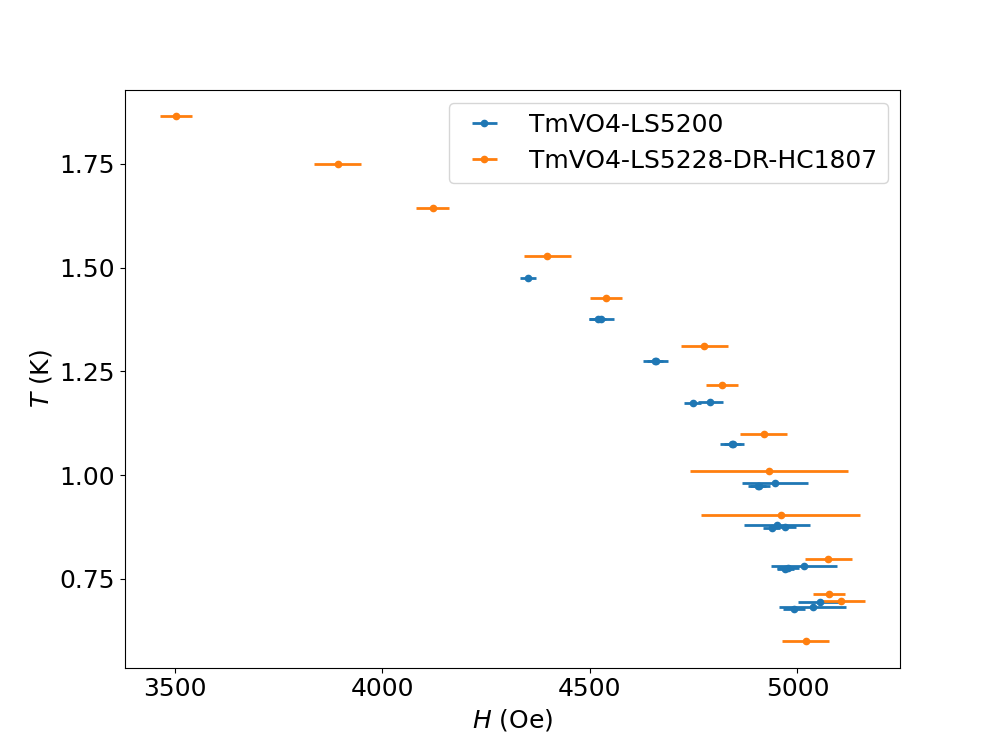

In [186]:
fig, ax = plt.subplots()
for idx in range(2):
    plt.errorbar(pbdata[idx]['Hc_inferred'], pbdata[idx]['Tc'], xerr=pbdata[idx]['dHc'], 
                 marker='.', ms=9, lw=0, elinewidth=2, label=f'{samples[idx]}')
ax.set_xlabel(r'$H$ (Oe)')
ax.set_ylabel(r'$T$ (K)')
ax.locator_params(nbins=6)
plt.legend()

## Fit data

### Fit with semi-classical model

In [252]:
def data_selection(data, temp_min=None, temp_max=None):
    if temp_max is None and temp_min is None:
        np.ones(data.shape, dtype=bool)
    elif temp_max is None:
        return data>temp_min
    elif temp_min is None:
        return data<temp_max
    else:
        return np.logical_and(data>temp_min, data<temp_max)

In [128]:
def sc_tfim(x):
    return x/np.arctanh(x)

def sc_tfim_residual(params, x, data, eps_data=None):
    pvals = params.valuesdict()
    Tc = pvals['Tc']
    Hc = pvals['Hc']
    
    model = Tc*sc_tfim(x/Hc)

    if eps_data is None:
        yres = (data-model)
    else:
        yres = (data-model)/eps_data
    return yres[~np.isnan(yres)]

In [263]:
sc_tfim_residual(sc_params, x, y, eps_data=dx)
len(y[y>1.5])

4

<IPython.core.display.Javascript object>


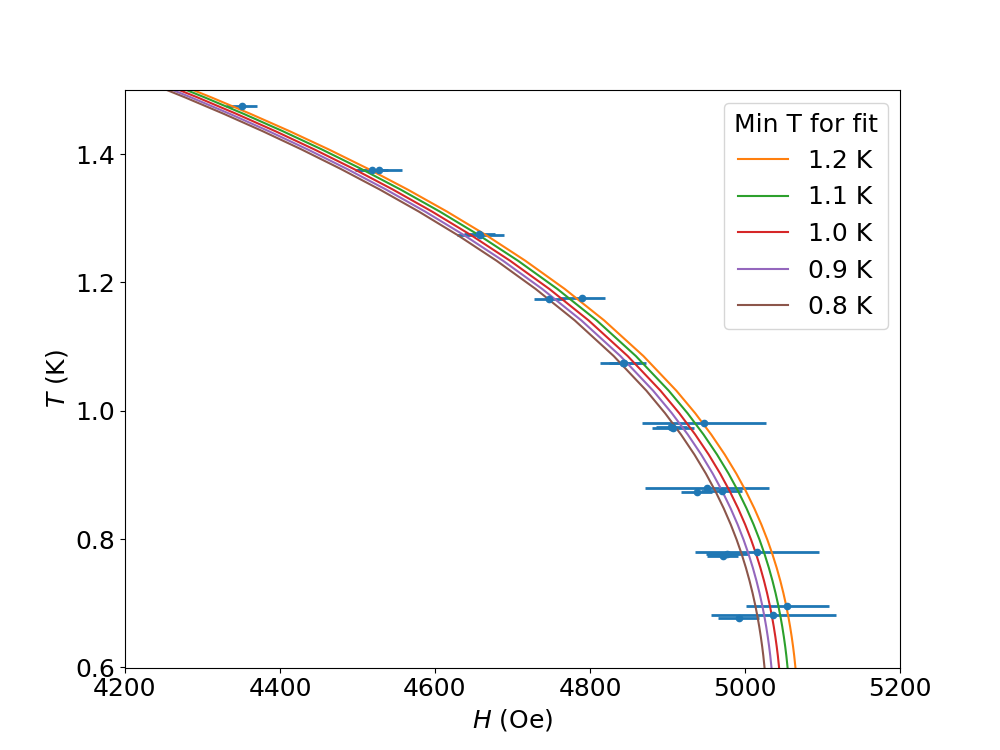

1.2 {'Ndata': 5, 'redchi/Ndata': 1.1882701231699e-08, 'Hc': 5071.8170214909305}
1.1 {'Ndata': 7, 'redchi/Ndata': 5.679856960301967e-08, 'Hc': 5061.658677580252}
1.0 {'Ndata': 9, 'redchi/Ndata': 5.824861459488353e-08, 'Hc': 5050.6775032578435}
0.9 {'Ndata': 12, 'redchi/Ndata': 5.7275454386736e-08, 'Hc': 5040.873734548582}
0.8 {'Ndata': 15, 'redchi/Ndata': 8.056298343784661e-08, 'Hc': 5031.892654083973}


<IPython.core.display.Javascript object>


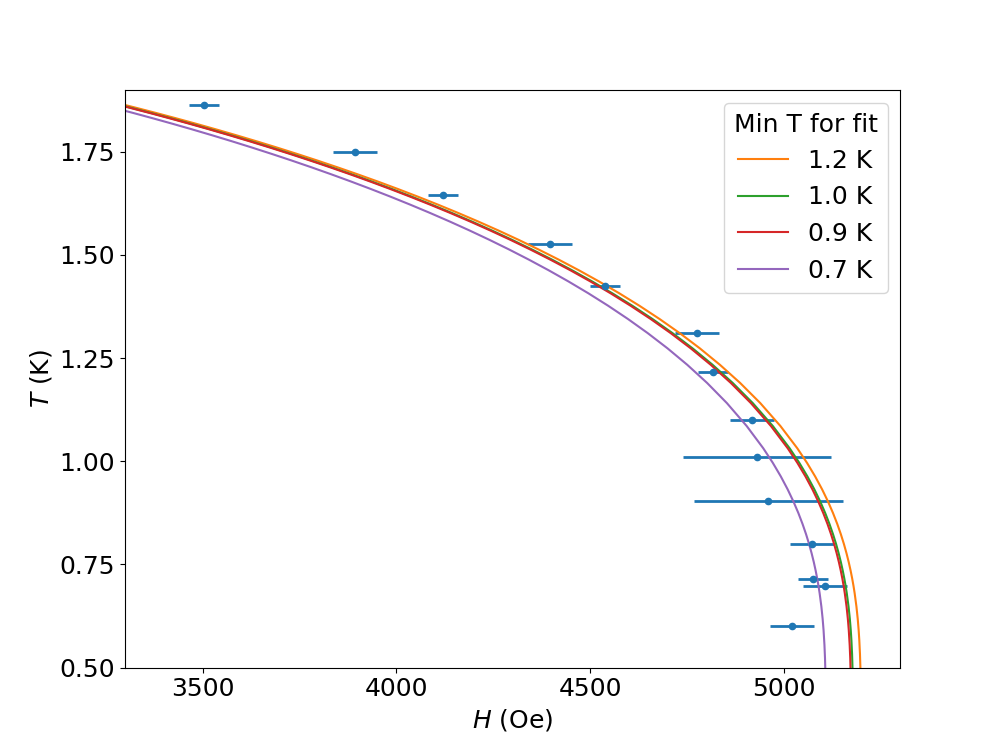

1.2 {'Ndata': 5, 'redchi/Ndata': 8.785584076118723e-08, 'Hc': 5199.399074345176}
1.0 {'Ndata': 7, 'redchi/Ndata': 7.203863791541036e-08, 'Hc': 5178.998608057355}
0.9 {'Ndata': 8, 'redchi/Ndata': 7.208274013371448e-08, 'Hc': 5173.860567829583}
0.7 {'Ndata': 10, 'redchi/Ndata': 1.2624162050529096e-07, 'Hc': 5108.719688465955}


In [266]:
sc_params = Parameters()
sc_params.add('Tc', value=2.2, vary=False)
sc_params.add('Hc', value=5.1e3)
sc_tmax = 1.7

sc_fit_list = [None]*2

for idx in range(2):
    x = pbdata[idx]['Hc_inferred']
    y = pbdata[idx]['Tc']
    dx = pbdata[idx]['dHc']
    sc_ylim = [round(np.max(y)-.25,1)]
    sc_fit_list[idx] = {}

    fig, ax = plt.subplots()
    plt.errorbar(x,y,xerr=dx, marker='.', ms=9, lw=0, elinewidth=2)
    while True:
        if sc_ylim[-1]<np.min(y): break

        ysel = data_selection(y, temp_max=sc_tmax, temp_min=sc_ylim[-1])
        # If the array of values used for the fit did not change, continue
        if len(y[ysel])<5 or len(sc_ylim)>=2 and np.array_equal(ysel, data_selection(y, temp_max=sc_tmax, temp_min=sc_ylim[-2])): 
            sc_ylim[-1] = round(sc_ylim[-1]-.1,1)
            continue

        try:
            out = minimize(sc_tfim_residual, sc_params, args=(x[ysel], y[ysel]), kws={'eps_data':dx[ysel]})
        except ValueError as verr:
    #         print(verr)
            break

        Tc = out.params['Tc'].value
        Hc = out.params['Hc'].value
        sc_fit_list[idx][sc_ylim[-1]] = {'Ndata':out.ndata, 'redchi/Ndata':out.redchi/out.ndata, 'Hc':Hc}

        xfit = np.concatenate([np.linspace(.01,.96,96),1-np.logspace(-1.5,-5)])*Hc
        yfit = Tc*sc_tfim(xfit/Hc)
        plt.plot(xfit, yfit, label=f'{sc_ylim[-1]} K')

        sc_ylim.append(round(sc_ylim[-1]-.1,1))

    plt.legend(title='Min T for fit')
    plt.xlim([round(np.min(x)-2e2,-2),round(Hc+2e2,-2)])
    plt.ylim([round(np.min(y)-.05,1), round(np.max(y)+.05,1)])
    pb_plot_settings(ax)
    
        
# sc_fit = tuple(sc_fit_list)
    for k, v in sc_fit_list[idx].items():
        print(k, v)

#### Conclusion
Best fit for sample LS5200 is for Tmin = 1.1 K, but good for all choices of Tmin
Best fit for sample LS5200 is for Tmin = 0.9 K

### Fit with Rafael's predictions

In [226]:
def rmf_residual(params, x, y, psi=.5, weights=None):
    """Compute the residual for fit using Rafael M. Fernandes' theoretical predictions."""
    pvals = params.valuesdict()
    A = pvals['A']
    Hc = pvals['Hc']
    
    model = A*abs(Hc-x)**psi

    if weights is None:
        yres = (y-model)
    else:
        yres = (y-model)/weights
        
    return yres[~np.isnan(yres)]

<IPython.core.display.Javascript object>


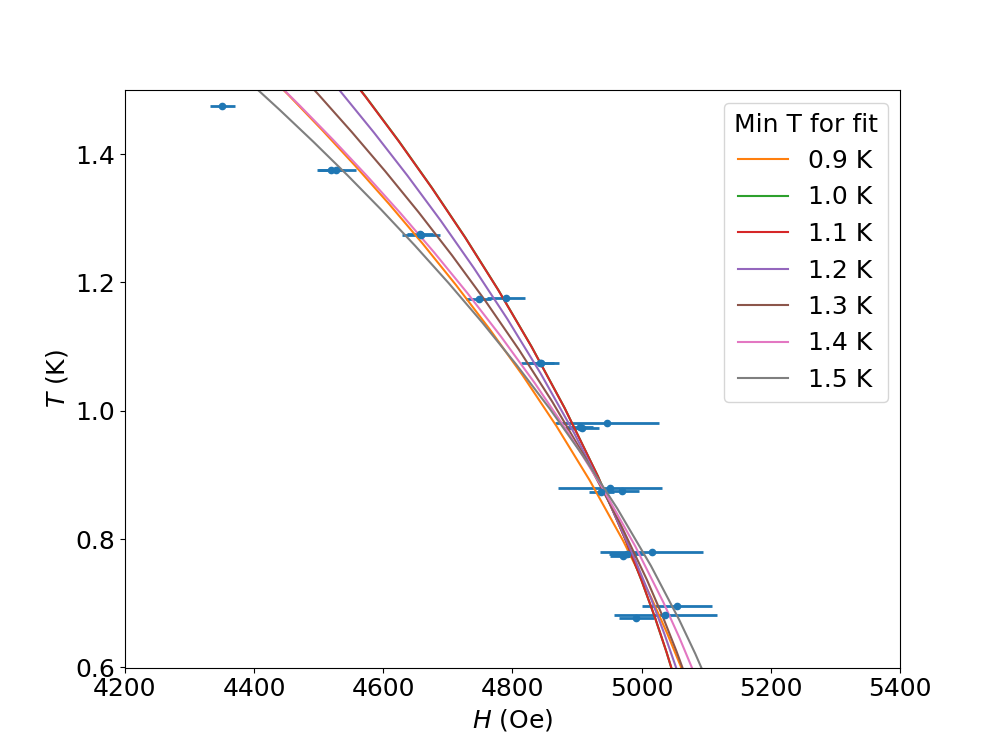

0.9 {'ndata': 9, 'redchi/Ndata': 3.455501245374517e-07, 'Hc': 5178.493407959784}
1.0 {'ndata': 12, 'redchi/Ndata': 2.3961265200575035e-07, 'Hc': 5137.553310826406}
1.1 {'ndata': 14, 'redchi/Ndata': 1.7119728715817864e-07, 'Hc': 5137.721867185002}
1.2 {'ndata': 16, 'redchi/Ndata': 1.555446872507389e-07, 'Hc': 5152.5820051796945}
1.3 {'ndata': 18, 'redchi/Ndata': 1.4591685412094775e-07, 'Hc': 5171.837529275334}
1.4 {'ndata': 20, 'redchi/Ndata': 1.616714786169939e-07, 'Hc': 5198.012144486263}
1.5 {'ndata': 21, 'redchi/Ndata': 2.0170441703078938e-07, 'Hc': 5223.26346413047}


<IPython.core.display.Javascript object>


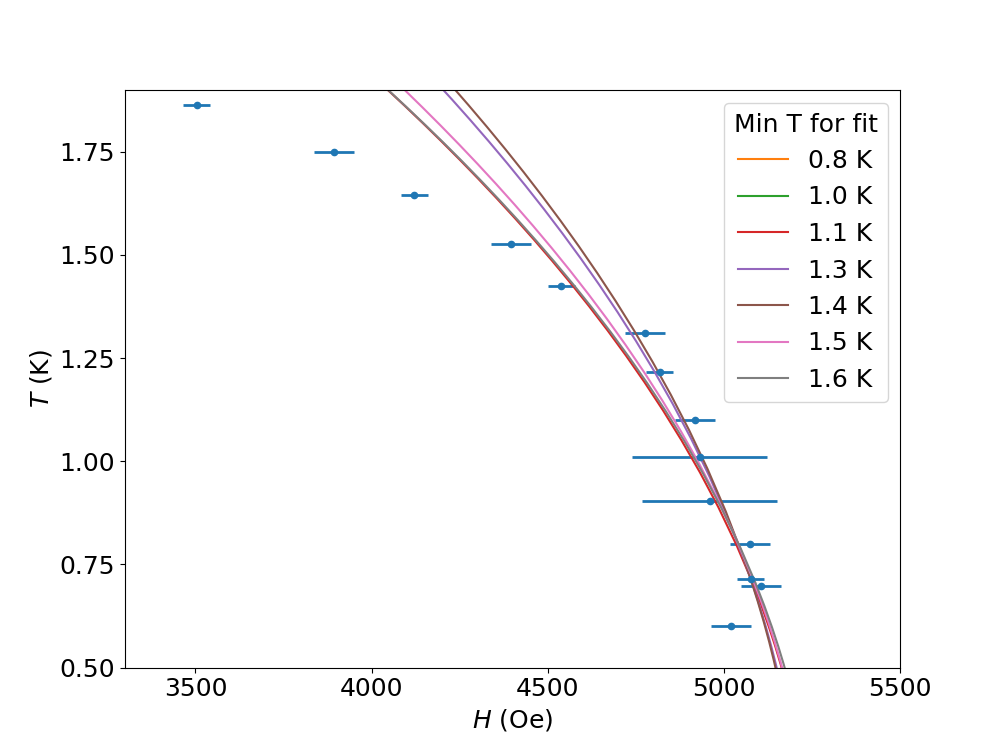

0.8 {'ndata': 4, 'redchi/Ndata': 7.803891338712145e-07, 'Hc': 10691762.796423538}
1.0 {'ndata': 5, 'redchi/Ndata': 4.866938852111058e-07, 'Hc': 6239001.535235157}
1.1 {'ndata': 7, 'redchi/Ndata': 6.263606728445899e-07, 'Hc': 5247.02166582989}
1.3 {'ndata': 8, 'redchi/Ndata': 4.788931549676169e-07, 'Hc': 5220.136064463971}
1.4 {'ndata': 9, 'redchi/Ndata': 3.756656445539121e-07, 'Hc': 5214.095838366812}
1.5 {'ndata': 10, 'redchi/Ndata': 3.772048407176241e-07, 'Hc': 5245.001689651278}
1.6 {'ndata': 11, 'redchi/Ndata': 3.2887637120689053e-07, 'Hc': 5256.253752794883}


In [267]:
rmf_params = Parameters()
rmf_params.add('A', value=1)# arbitrary multiplying factor
rmf_params.add('Hc', value=5.2e3)# Critical field
psi = .5# exponent of power law fit
tmin = None

rmf_fit_list = [None]*2

for idx in range(2):
    x = pbdata[idx]['Hc_inferred']
    y = pbdata[idx]['Tc']
    dx = pbdata[idx]['dHc']
    rmf_ylim = [round(np.min(y)+.25,1)]
    rmf_fit_list[idx] = {}

    fig, ax = plt.subplots()
    plt.errorbar(x, y, xerr=dx, marker='.', ms=9, lw=0, elinewidth=2)
    
    while rmf_ylim[-1]<1.7:
#         if rmf_ylim[-1]>np.max(y): break

        ysel = data_selection(y, temp_max=rmf_ylim[-1], temp_min=tmin)
        # If the array of values used for the fit did not change, continue
        if len(rmf_ylim)>=2 and np.array_equal(ysel, data_selection(y, temp_max=rmf_ylim[-2], temp_min=tmin)): 
            rmf_ylim[-1] = round(rmf_ylim[-1]+.1,1)
            continue

        # Try fit of data using the residual function
        try:
            out = minimize(rmf_residual, rmf_params, args=(x[ysel], y[ysel]), 
                           kws={'psi':psi, 'weights':dx[ysel]}, nan_policy='omit')
        except ValueError as verr:
            print(verr)
            break

        A = out.params['A'].value
        Hc = out.params['Hc'].value
        rmf_fit_list[idx][rmf_ylim[-1]] = {'ndata':out.ndata,'redchi/Ndata':out.redchi/out.ndata, 'Hc':Hc}

        xfit = np.concatenate([np.linspace(.01,.96,96),1-np.logspace(-1.5,-5)])*Hc
        yfit = A*(Hc-xfit)**psi
        plt.plot(xfit, yfit, label=f'{rmf_ylim[-1]} K')

        rmf_ylim.append(round(rmf_ylim[-1]+.1,1))

    plt.legend(title='Min T for fit')
    plt.xlim([round(np.min(x)-2e2,-2),round(Hc+2e2,-2)])
    plt.ylim([round(np.min(y)-.05,1), round(np.max(y)+.05,1)])
    pb_plot_settings(ax)
    
        
# rmf_fit = tuple(rmf_fit_list)
    for k, v in rmf_fit_list[idx].items():
        print(k, v)

#### Conclusion
- Best fit for sample LS5200 is for Tmax = 1.3K
- Best fit for sample LS5228 is for Tmax = 1.4K

#### To do as of 2021-05-31
Convert code to a function and apply for psi = 1/4, 2/5 and 2/3